In [1]:
import re
import math
import time

import xgboost as xgb
import pandas as pd 
import numpy as np 
import seaborn as sns 

from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
pd.set_option('max_columns', None)
pd.set_option('display.float_format', str)
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9,5]
plt.rcParams["axes.edgecolor"] = "black"

## Machine Learning Notebook

### Training data

In [2]:
#load training data
df = pd.read_csv('datasets/train.csv')

In [3]:
df.head()

,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,maid_room,unfurnished,balcony,barbecue_area,built_in_wardrobes,central_ac,childrens_play_area,childrens_pool,concierge,covered_parking,kitchen_appliances,lobby_in_building,maid_service,networked,pets_allowed,private_garden,private_gym,private_jacuzzi,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet,num_venues,venue_senti,population_density,num_stations,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,0.4383081653381801,0.962355909433262,2700000,0.0845722904546434,0.4816494149414941,0.2,0.2,0.3333333333333333,0,0,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.438196481719345,0.9625700438791892,2850000,0.138763197586727,0.3239536453645364,0.4,0.2,0.3333333333333333,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4374371413216798,0.962334895669068,1150000,0.178517560870502,0.0512083708370837,0.6000000000000001,0.8,0.3333333333333333,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,0.5050505050505052,0.7076226940480348,0.1798788778884154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4402993591219029,0.9658959433017896,2850000,0.1859513035983624,0.236053105310531,0.4,0.4000000000000001,0.0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1717171717171717,0.5917159763313613,0.0302598543085124,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4383267880012989,0.9623704305726386,1729200,0.0229476405946994,0.6860441044104411,0.0,0.0,0.3333333333333333,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.describe()

,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,maid_room,unfurnished,balcony,barbecue_area,built_in_wardrobes,central_ac,childrens_play_area,childrens_pool,concierge,covered_parking,kitchen_appliances,lobby_in_building,maid_service,networked,pets_allowed,private_garden,private_gym,private_jacuzzi,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet,num_venues,venue_senti,population_density,num_stations,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
count,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0,1844.0
mean,0.43835643982020267,0.9636010210842592,2107441.4446854666,0.12134365676856447,0.2199066766763443,0.36008676789587707,0.3043383947939237,0.29266088214027186,0.14696312364425163,0.6382863340563991,0.722885032537961,0.1442516268980477,0.7125813449023861,0.6832971800433839,0.3362255965292842,0.08731019522776573,0.36388286334056397,0.6193058568329718,0.36550976138828634,0.10629067245119306,0.0824295010845987,0.061279826464208244,0.2928416485900217,0.016811279826464208,0.008134490238611713,0.05151843817787419,0.04392624728850325,0.3557483731019523,0.6664859002169198,0.7413232104121475,0.10466377440347072,0.10303687635574837,0.04772234273318872,0.21475054229934923,0.34869848156182215,0.1540130151843818,0.6258627489646974,0.8006465317272932,0.19653188818313175,0.20634490238611713,0.0021691973969631237,0.10845986984815618,0.00596529284164859,0.014642082429501085,0.013557483731019523,0.0021691973969631237,0.0113882863340564,0.00596529284164859,0.0027114967462039045,0.020607375271149676,0.003796095444685466,0.0005422993492407809,0.004338394793926247,0.03796095444685466,0.0021691973969631237,0.04772234273318872,0.007592190889370932,0.014642082429501085,0.17299349240780912,0.05260303687635575,0.0010845986984815619,0.028741865509761388,0.01843817787418655,0.021149674620390455,0.0027114967462039045,0.0005422993492407809,0.23969631236442515,0.0032537960954446853,0.009219088937093275,0.006507592190889371,0.09652928416485901,0.004338394793926247,0.0010845986984815619,0.0070498915401301515,0.0016268980477223427,0.022234273318872018,0.0005422993492407809,0.0032537960954446853
std,0.0010786430273665394,0.0011905415005681488,2949678.5712087657,0.09664302802651951,0.15119537290161283,0.19041375703937943,0.21369967014200125,0.23926220665951942,0.35416519614404257,0.4806268429202072,0.44769515950865624,0.3514400012353796,0.4526812343634368,0.46531662575693467,0.47254527792764595,0.28236565435777067,0.48124600819195457,0.48568923985248164,0.4817034460001131,0.3082928931647468,0.2750925615794092,0.2399079444650429,0.4551898292610681,0.128598713222678,0.08984819489622355,0.22111264585224324,0.2049866318704591,0.4788693203374535,0.47159628291627953,0.43802643476285213,0.30620273476950005,0.3040895018213589,0.21323596990252439,0.4107605700773312,0.4766876102689455,0.3610591398777004,0.419043672551709,0.14819378539012912,0.12443008511563262,0.3007819116097998,0.04653672118989327,0.3110446805337042,0.07702548633162805,0.12014790978145659,0.11567599075935285,0.04653672118989363,0.10613530095615227,0.07702548633162802,0.052015495605718005,0.14210440656624235,0.0615120884232113,0.023287321641631113,0.06574128761485612,0.19115369695435275,0.04653672118989337,0.21323596990252333,0.0868253288228903,0.12014790978145812,0.37834424944968653,0.22330024195942955,0.032924310200398474,0.16712545465971124,0.134

In [5]:
df.columns

Index(['latitude', 'longitude', 'price', 'size_in_sqft', 'price_per_sqft',
       'no_of_bedrooms', 'no_of_bathrooms', 'quality', 'maid_room',
       'unfurnished', 'balcony', 'barbecue_area', 'built_in_wardrobes',
       'central_ac', 'childrens_play_area', 'childrens_pool', 'concierge',
       'covered_parking', 'kitchen_appliances', 'lobby_in_building',
       'maid_service', 'networked', 'pets_allowed', 'private_garden',
       'private_gym', 'private_jacuzzi', 'private_pool', 'security',
       'shared_gym', 'shared_pool', 'shared_spa', 'study', 'vastu_compliant',
       'view_of_landmark', 'view_of_water', 'walk_in_closet', 'num_venues',
       'venue_senti', 'population_density', 'num_stations', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', '31', '32', '33', '34', '35', '36', '37'],
      dtype='object')

## Split into test train split (holdout CV)

In [6]:
# Target column
y = df['price']

# Feature columns and matrix
features = [col for col in df.columns if col not in ('price','price_per_sqft')]
X = df[features]

# Create the test train split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.2)

In [7]:
# Just getting some info
print(f'Original dataset is {X.shape[0]} rows and {X.shape[1]} columns.')
print(f'Training dataset is {train_X.shape[0]} rows and {train_X.shape[1]} columns.')
print(f'Testing dataset is {val_X.shape[0]} rows and {val_X.shape[1]} columns.')

Original dataset is 1844 rows and 76 columns.
Training dataset is 1475 rows and 76 columns.
Testing dataset is 369 rows and 76 columns.


## Test create a testing helper function

In [8]:
def test(model):
    '''
    This function improves QOL for the programmer 
    by allowing to run tests fast without writing code over and over,
    to evaluate a models performance.
    
    '''
    # Fir and predict model
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)
    
    # extract line of best fit statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(val_y,y_pred)
    
    # Print out results
    print(f'MAE = {mean_absolute_error(val_y, y_pred):.2f} AED')
    print(f'RMSE = {mean_squared_error(val_y, y_pred, squared = 0):.2f} AED')
    print(f'Normalized RMSE = {(mean_squared_error(val_y, y_pred, squared = 0))/(val_y.max() - val_y.min()):.2f} AED')
    print(f'Model accuracy (1 - MAPE) % = {(1 - mean_absolute_percentage_error(val_y, y_pred))*100:.2f} %')
    print(f'r = {r_value:.2f}, p = {p_value:.2f}, err = {std_err:.2f}')
    
    # Extract name from model __class__
    model_name = re.findall(r'(?<=\.)[a-zA-Z]+(?=\')',str(model.__class__))[0]
  

    # plot A vs. P plot with regression line
    sns.regplot(x = val_y, y = y_pred, line_kws = {'label': f' y = {slope:.1f} x + {intercept:.1f}'})
    plt.legend()
    plt.title(f'{model_name}')
    plt.xlabel('Actual Price (AED)')
    plt.ylabel('Predicted Price (AED)')
    plt.show()


## Initial test with XGB (all default settings)

Doing some initial testing for hyperparameter tuning.

MAE = 482732.71 AED
RMSE = 1491073.48 AED
Normalized RMSE = 0.04 AED
Model accuracy (1 - MAPE) % = 81.48 %
r = 0.90, p = 0.00, err = 0.02


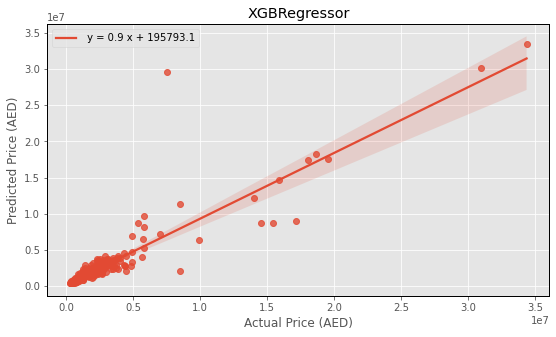

In [9]:
xgb_model = xgb.XGBRegressor()
test(xgb_model)

## Test with some other models for a sanity check

MAE = 998547.57 AED
RMSE = 1683575.61 AED
Normalized RMSE = 0.05 AED
Model accuracy (1 - MAPE) % = 42.70 %
r = 0.87, p = 0.00, err = 0.02


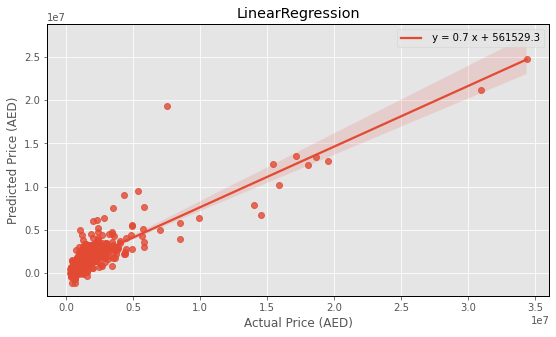

In [10]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()
test(linear_reg_model)

MAE = 770540.49 AED
RMSE = 2000560.25 AED
Normalized RMSE = 0.06 AED
Model accuracy (1 - MAPE) % = 71.11 %
r = 0.83, p = 0.00, err = 0.03


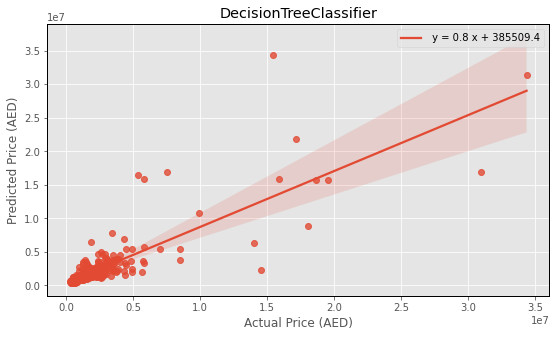

In [11]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
test(tree_model)

MAE = 505505.94 AED
RMSE = 1432119.34 AED
Normalized RMSE = 0.04 AED
Model accuracy (1 - MAPE) % = 79.75 %
r = 0.91, p = 0.00, err = 0.02


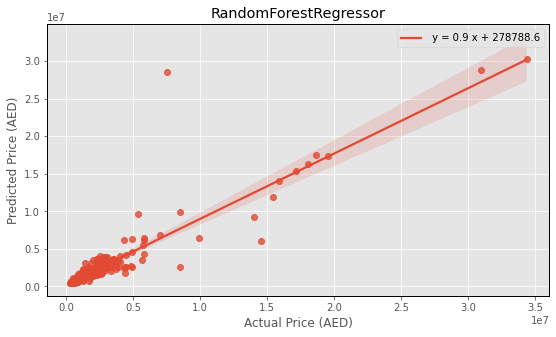

In [12]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=1)
test(forest_model)

MAE = 1263055.30 AED
RMSE = 3613708.04 AED
Normalized RMSE = 0.11 AED
Model accuracy (1 - MAPE) % = 57.39 %
r = 0.41, p = 0.00, err = 0.04


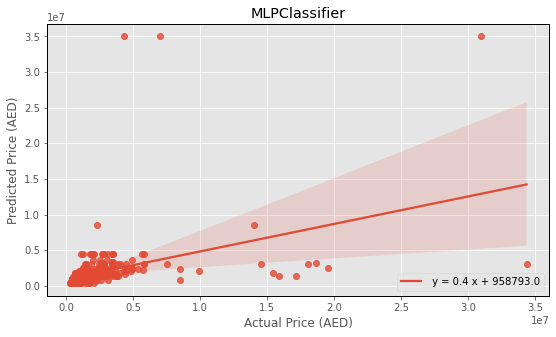

In [13]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
test(nn_model)

Seems to me going forward with XGB makes sense.

## Hyperparamter tuning XGB

### Gridsearch 

In [14]:
# Parameter dictionary for combinations with feasibile values
params = { 'max_depth': np.linspace(3,10,4).astype(int),
           'learning_rate': np.linspace(0.01,1,4),
           'n_estimators': np.linspace(100,1000,4).astype(int),
           'colsample_bytree': np.linspace(0.01,1,4)}


xgb_gs = xgb.XGBRegressor(seed = 20)

# THIS IS GOING TO TAKE SO LONG!!! I should benchmark it !

start = time.time()

clf = GridSearchCV(estimator = xgb_gs, 
                   param_grid = params,
                   scoring = 'neg_mean_squared_error', 
                   verbose = 1)
clf.fit(X, y)

end = time.time()

print(f'It only took {(end-start)//60} minutes. \n')
print("Best parameters: \n", clf.best_params_)
print("\nLowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
It only took 21.0 minutes. 

Best parameters: 
 {'colsample_bytree': 0.01, 'learning_rate': 0.34, 'max_depth': 5, 'n_estimators': 1000}

Lowest RMSE:  1151474.0262342151


MAE = 586615.38 AED
RMSE = 1289409.33 AED
Normalized RMSE = 0.04 AED
Model accuracy (1 - MAPE) % = 71.96 %
r = 0.93, p = 0.00, err = 0.02


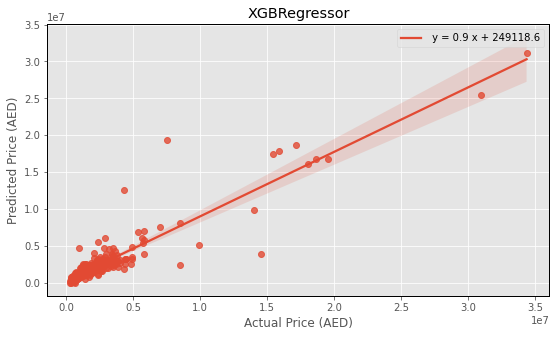

In [15]:
# Using the tuned hyper parameters from before
xgb_model_tuned = xgb.XGBRegressor(colsample_bytree = 0.01,
                                   learning_rate = 0.34,
                                   max_depth=  5,
                                   n_estimators = 1000)
test(xgb_model_tuned)

In [16]:
# Percentage RMSE reduction.
(1289409.33/1491073.48)*100

86.47523729011665

## Show Tree

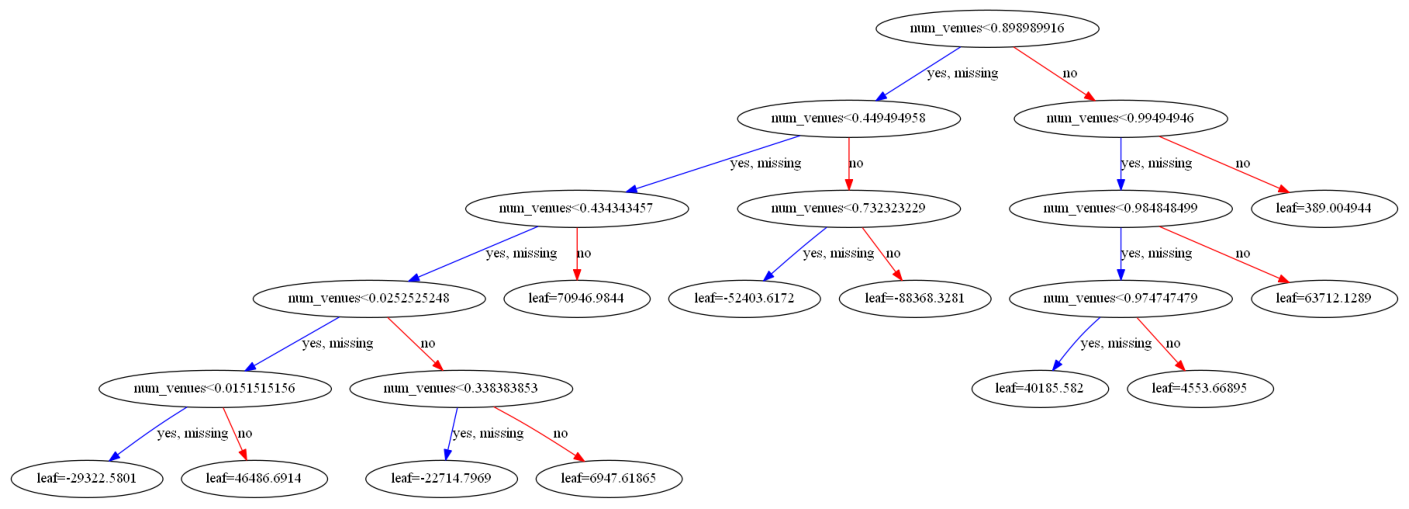

In [17]:
plt.rcParams['figure.figsize'] = [25,10]
xgb.plot_tree(xgb_model_tuned,num_trees = 56)
plt.show()

### Feature importance

In [19]:
xgb_model_tuned.feature_importances_

array([2.23329775e-02, 7.99071193e-02, 4.20314223e-01, 7.30387261e-03,
       7.25846365e-02, 5.15807653e-04, 3.10403071e-02, 1.18004056e-02,
       2.34018022e-04, 5.46820636e-04, 7.94274919e-03, 5.05440810e-04,
       3.78762297e-02, 5.20409271e-03, 2.61634476e-02, 3.90097150e-03,
       2.73239420e-04, 5.99655323e-05, 3.18337086e-04, 5.06546989e-04,
       1.80090824e-03, 9.21139363e-05, 1.41940499e-03, 2.05270294e-03,
       1.13359585e-01, 2.46673101e-03, 1.46044197e-03, 5.20499703e-03,
       6.36421202e-04, 1.13174657e-03, 5.78839608e-05, 9.16863966e-04,
       7.26424623e-03, 2.34471401e-03, 2.91320402e-03, 3.05579917e-04,
       5.36012412e-05, 1.69375613e-02, 1.19576780e-05, 2.33085913e-04,
       9.71903282e-05, 5.80642663e-04, 4.01186349e-04, 5.43979922e-06,
       8.73769095e-05, 1.01024350e-02, 1.01117083e-04, 1.51855493e-05,
       5.00816986e-06, 9.11281677e-04, 2.05860015e-05, 3.18449136e-04,
       6.56363363e-06, 6.20974242e-05, 3.83798196e-03, 1.15472870e-03,
      

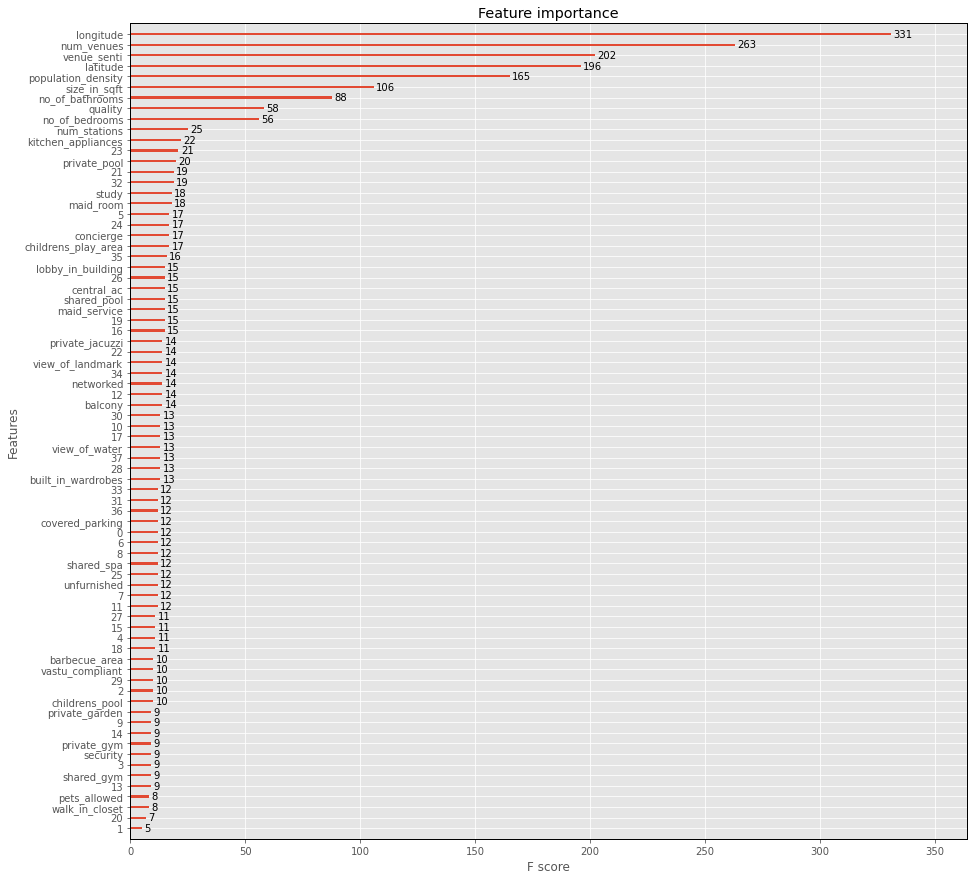

In [18]:
plt.rcParams['figure.figsize'] = [15,15]
xgb.plot_importance(xgb_model_tuned)
plt.show()